In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mnist import MNIST
from time import time

In [2]:
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255)
print("Done.")

Loading dataset....
Done.


In [3]:
def one_hot_encode(labels):
    y_inp=np.zeros((len(labels),10))
    for ind,val in enumerate(labels):
        y_inp[ind][val]=1
    return y_inp

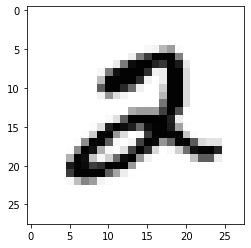

In [4]:
plt.imshow(X_train[5].reshape(28,28), cmap='Greys')
plt.show()

In [5]:
def batch_gen(st=0,size=20,validate=False):
    st=st%60000
    if validate:
        X=X_test[st:st+size].reshape(-1,28,28,1)
        labels=y_test[st:st+size]
    else:
        X=X_train[st:st+size].reshape(-1,28,28,1)
        labels=y_train[st:st+size]
    y=one_hot_encode(labels)
    return X,y

In [6]:
import cnn_new as cnn
import nnet

In [7]:
nn=cnn.conv_net()
ann=nnet.neural_net()

# Inititalize filters and bias

In [8]:
w0,b0=nn.init_kernel_bias(num_inp_channels=1,kernel_size=3,num_kernels=6)
w1,b1=nn.init_kernel_bias(num_inp_channels=6,kernel_size=3,num_kernels=16)

In [9]:
fw0,fb0=ann.init_weights_bias(num_inp=784,num_out=128)
fw1,fb1=ann.init_weights_bias(num_inp=128,num_out=32)
fw2,fb2=ann.init_weights_bias(num_inp=32,num_out=10)

# Initialize fully connected layer

In [10]:
nn.learning_rate=0.01
ann.learning_rate=0.01

# CNN and FC with backprop

In [11]:
def train(inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,fw0,fb0,fw1,fb1,fw2,fb2
#     # Feed Forward
    conv0=nn.conv2d(inp,w0,b0)
    aconv0=nn.relu(conv0)
    pool0,mask0=nn.max_pool(aconv0)

    conv1=nn.conv2d(pool0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,mask1=nn.max_pool(aconv1)

    r,c,d=pool1.shape[1:]
    flat=pool1.reshape(-1,r*c*d)

    fc0=ann.feed_forward(flat,fw0,fb0)
    afc0=ann.relu(fc0)
    fc1=ann.feed_forward(afc0,fw1,fb1)
    afc1=ann.relu(fc1)
    fc2=ann.feed_forward(afc1,fw2,fb2)
    afc2=ann.softmax(fc2)
    #Backprop ANN
    d_fc2=ann.del_cross_soft(afc2,y_inp)
#     d_fc2=ann.mean_squared_error_der(afc2,y_inp)
#     d_fc2=d_fc2*ann.sigmoid_der(afc2)
    d_fc1,d_fw2,d_fb2=ann.backprop(errors=d_fc2,inp=afc1,weights=fw2,biases=fb2)
    fw2+=d_fw2
    fb2+=d_fb2
    d_fc1[fc1<=0]=0
#     d_fc1=d_fc1*ann.sigmoid_der(afc1)
    d_fc0,d_fw1,d_fb1=ann.backprop(errors=d_fc1,inp=afc0,weights=fw1,biases=fb1)
    fw1+=d_fw1
    fb1+=d_fb1

    d_fc0[fc0<=0]=0
#     d_fc0=d_fc0*ann.sigmoid_der(afc0)
    err1,d_fw0,d_fb0=ann.backprop(errors=d_fc0,inp=flat,weights=fw0,biases=fb0)
    fw0+=d_fw0
    fb0+=d_fb0

#     # Back prop CNN
    err1=err1.reshape(-1,r,c,d)
    d_conv1=nn.max_pool_back(errors=err1,inp=aconv1,mask=mask1)
    d_conv1[conv1<=0]=0
    d_pool0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=pool0,kernels=w1,biases=b1)
    w1+=d_w1
    b1+=d_b1

    d_conv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,mask=mask0)
    d_conv0[conv0<=0]=0
    d_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=inp,kernels=w0,biases=b0,layer=0)
    w0+=d_w0
    b0+=d_b0

    ans=afc2.argmax(axis=1)
    cor=y_inp.argmax(axis=1)
    return ans,cor,afc2

In [12]:
def validate(inp,y_inp):
    global w0,b0,w1,b1,w2,b2,w3,b3,fw0,fb0,fw1,fb1,fw2,fb2
    # Feed Forward
    conv0=nn.conv2d(inp,w0,b0)
    aconv0=nn.relu(conv0)
    pool0,mask0=nn.max_pool(aconv0)

    conv1=nn.conv2d(pool0,w1,b1)
    aconv1=nn.relu(conv1)
    pool1,mask1=nn.max_pool(aconv1)

#     pool1=inp
    r,c,d=pool1.shape[1:]
    flat=pool1.reshape(-1,r*c*d)
    
    fc0=ann.feed_forward(flat,fw0,fb0)
    afc0=ann.relu(fc0)
    fc1=ann.feed_forward(afc0,fw1,fb1)
    afc1=ann.relu(fc1)
    fc2=ann.feed_forward(afc1,fw2,fb2)
    afc2=ann.softmax(fc2)
    
    ans=afc2.argmax(axis=1)
    cor=y_inp.argmax(axis=1)
    return ans,cor,afc2

In [13]:
losses=[]
val_losses=[]
train_acc=[]
val_acc=[]

In [14]:
def run():
    st=0
    btsz=8
    cuts=(((60000*np.arange(11)/10))//btsz)*btsz
    while st<=60000:
        perc=st/600
        ck=np.random.randint(0,60000-btsz)
        inp,y_inp=batch_gen(ck,size=btsz)
        ans,cor,ott=train(inp,y_inp)
        acc=100*(ans==cor).mean()
#         loss=ann.mean_squared_error(ott,y_inp).sum(axis=1).mean()
        cross_entropy=ann.cross_entropy_with_logits(logits=ott,labels=y_inp)
        loss=cross_entropy.sum()
        losses.append(loss)
        train_acc.append(acc)
        print("\rProgress: {:.2f} %\tAcc: {:.2f} %\tloss: {:.4f}".format(perc,acc,loss),end='')
        if st in cuts:
            print("\nCalculating Validation acc...",end='')
            sz=4000
#             ck=0
            ck=np.random.randint(0,10000-sz)
            inp,y_inp=batch_gen(ck,size=sz,validate=True)
            ans,cor,ott=validate(inp,y_inp)
            acc=100*(ans==cor).mean()
#             loss=ann.mean_squared_error(ott,y_inp).sum(axis=1).mean()
            cross_entropy=ann.cross_entropy_with_logits(logits=ott,labels=y_inp)
            loss=cross_entropy.sum()
            print("\rValidation Acc: {:.2f} %\t\tVal loss: {:.4f}".format(acc,loss))
            val_losses.append(loss)
            val_acc.append(acc)
            if acc>=96:
                nn.learning_rate=0.00001
                ann.learning_rate=0.00001
            elif acc>=93:
                nn.learning_rate=0.0001
                ann.learning_rate=0.0001
            elif acc>=90:
                nn.learning_rate=0.001
                ann.learning_rate=0.001
        st+=btsz

In [15]:
for i in range(2):
    run()

Progress: 0.00 %	Acc: 12.50 %	loss: 2.3428
Validation Acc: 13.45 %		Val loss: 2.3157
Progress: 10.00 %	Acc: 75.00 %	loss: 0.6086
Validation Acc: 82.67 %		Val loss: 0.5740
Progress: 20.00 %	Acc: 100.00 %	loss: 0.0560
Validation Acc: 93.45 %		Val loss: 0.2153
Progress: 30.00 %	Acc: 75.00 %	loss: 0.57132
Validation Acc: 88.52 %		Val loss: 0.3648
Progress: 40.00 %	Acc: 87.50 %	loss: 0.25870
Validation Acc: 91.15 %		Val loss: 0.2791
Progress: 50.00 %	Acc: 100.00 %	loss: 0.0621
Validation Acc: 90.33 %		Val loss: 0.3200
Progress: 60.00 %	Acc: 100.00 %	loss: 0.1336
Validation Acc: 95.23 %		Val loss: 0.1540
Progress: 70.00 %	Acc: 87.50 %	loss: 0.17668
Validation Acc: 94.88 %		Val loss: 0.1664
Progress: 80.00 %	Acc: 87.50 %	loss: 0.23044
Validation Acc: 95.50 %		Val loss: 0.1500
Progress: 90.00 %	Acc: 87.50 %	loss: 0.36627
Validation Acc: 93.03 %		Val loss: 0.2286
Progress: 100.00 %	Acc: 100.00 %	loss: 0.0918
Validation Acc: 95.12 %		Val loss: 0.1623
Progress: 0.00 %	Acc: 100.00 %	loss: 0.0900
V

In [16]:
nn.learning_rate,ann.learning_rate

(1e-05, 1e-05)

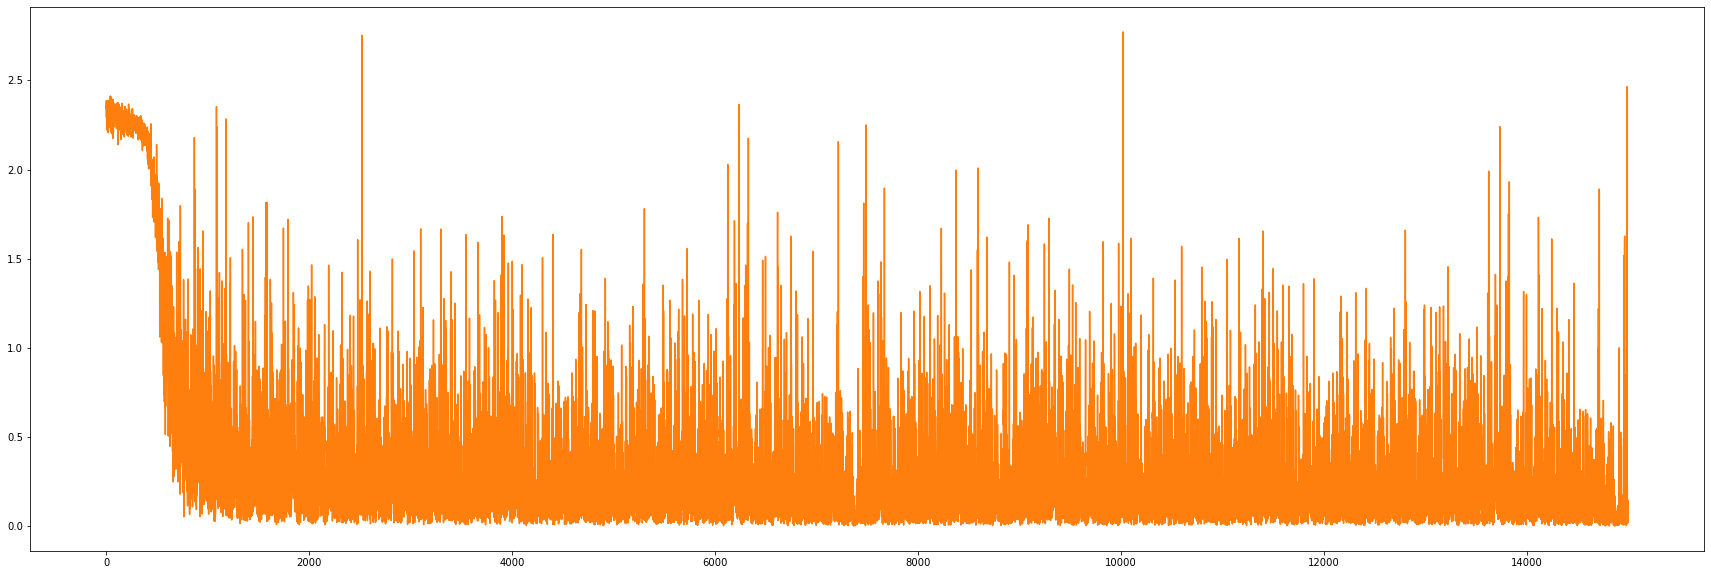

In [17]:
plt.figure(figsize=(30,10))
plt.plot(losses,color='#ff7f0e')
plt.show()

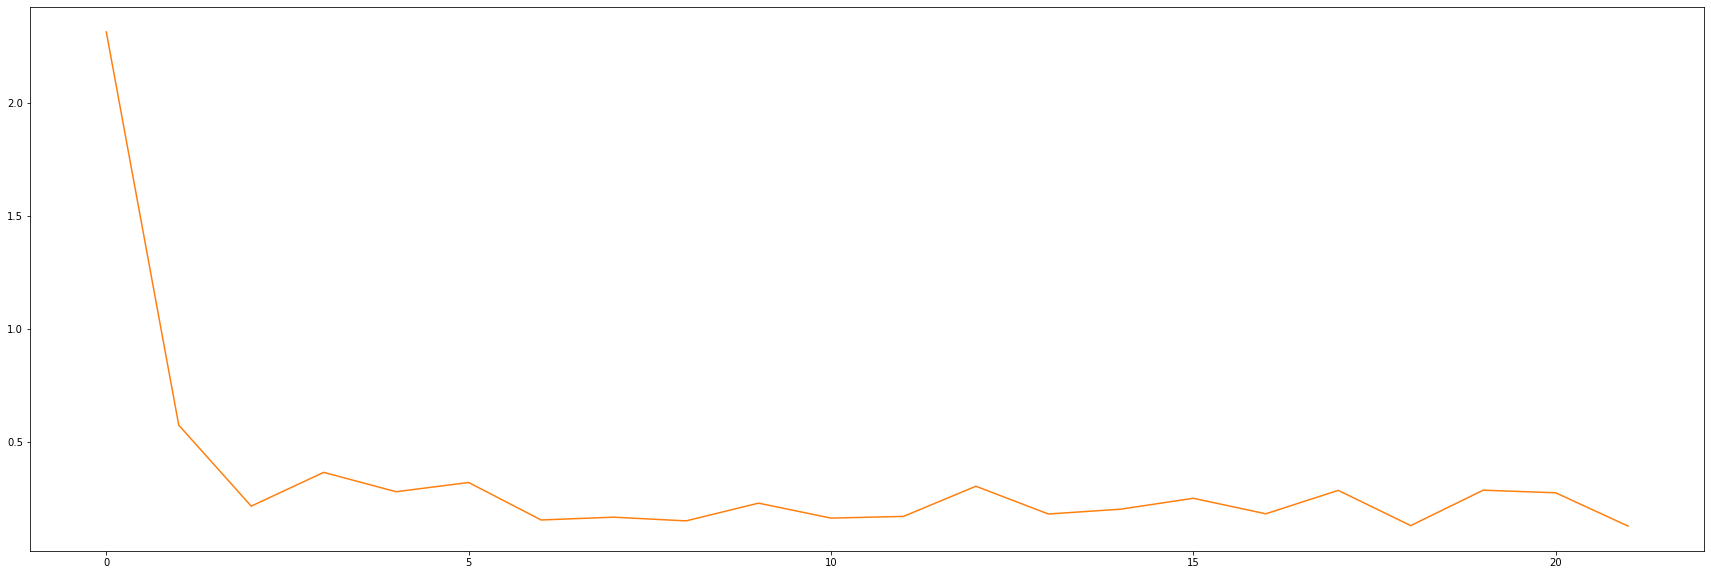

In [18]:
plt.figure(figsize=(30,10))
plt.plot(val_losses,color='#ff7f0e')
plt.show()

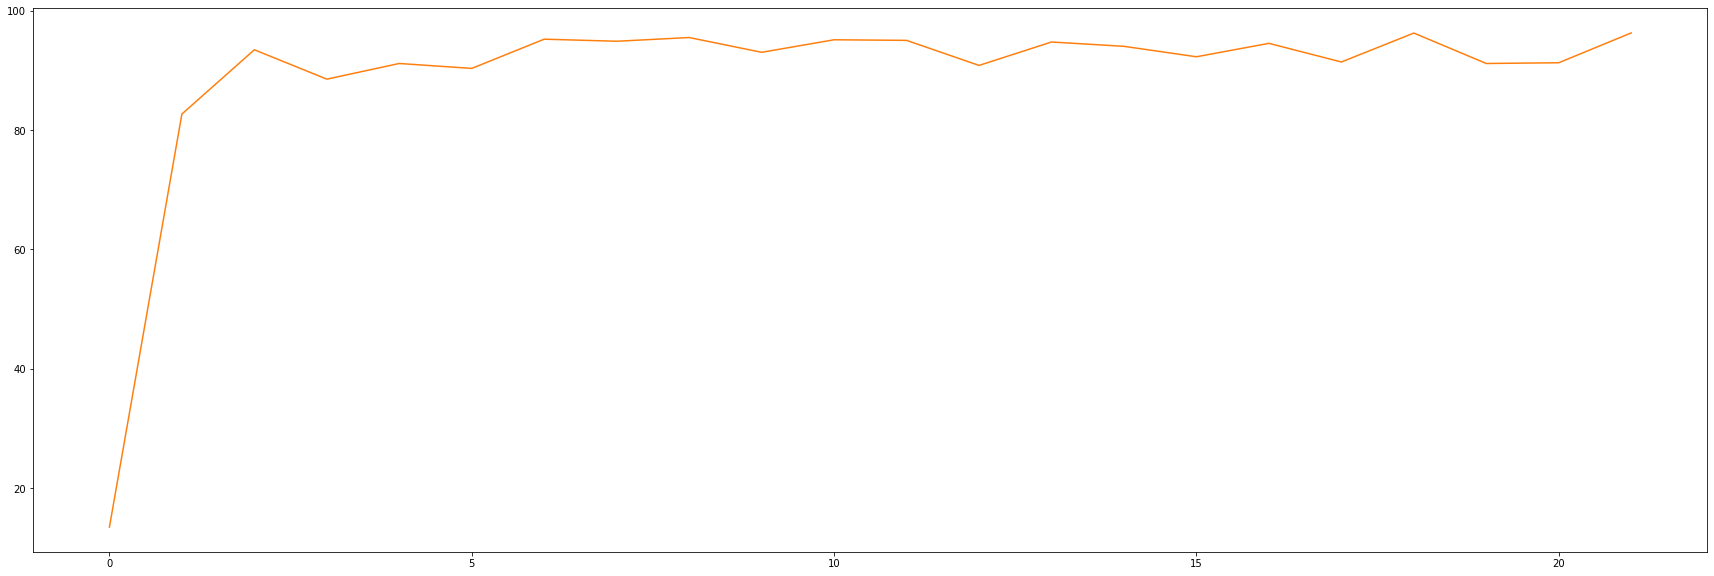

In [19]:
plt.figure(figsize=(30,10))
plt.plot(val_acc,color='#ff7f0e')
plt.show()

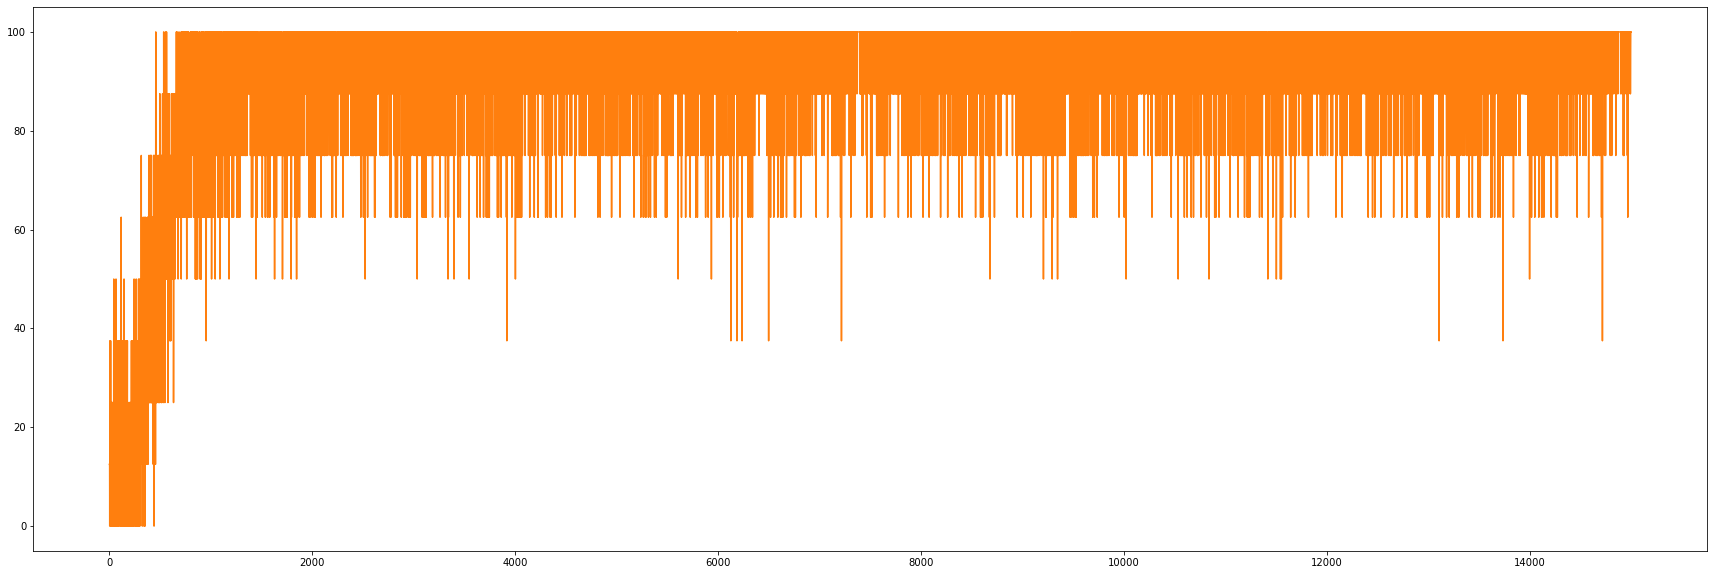

In [20]:
plt.figure(figsize=(30,10))
plt.plot(train_acc,color='#ff7f0e')
plt.show()

Prediction: [4] 
Correct:    [4]


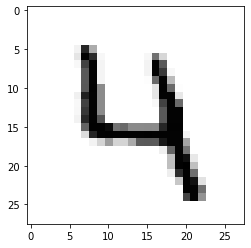

In [21]:
ck=np.random.randint(0,60000-100)
inp,y_inp=batch_gen(ck,size=1)
ans,cor,ott=validate(inp,y_inp)
print("Prediction:",ans,"\nCorrect:   ",cor)
plt.imshow(inp[0].reshape(28,28), cmap='Greys')

In [22]:
conv0=nn.conv2d(inp,w0,b0)
aconv0=nn.relu(conv0)
pool0,mask0=nn.max_pool(aconv0)

conv1=nn.conv2d(pool0,w1,b1)
aconv1=nn.relu(conv1)
pool1,mask1=nn.max_pool(aconv1)
r,c,d=pool1.shape[1:]
flat=pool1.reshape(-1,r*c*d)

fc0=ann.feed_forward(flat,fw0,fb0)
afc0=ann.relu(fc0)
fc1=ann.feed_forward(afc0,fw1,fb1)
afc1=ann.relu(fc1)
fc2=ann.feed_forward(afc1,fw2,fb2)
afc2=ann.softmax(fc2)
ott=afc2
#Backprop ANN
cross_entropy=ann.cross_entropy_with_logits(logits=afc2,labels=y_inp)
loss=cross_entropy.sum()

# d_fc2=ann.mean_squared_error_der(afc2,y_inp)
# d_fc2=d_fc2*ann.sigmoid_der(afc2)

d_fc2=ann.del_cross_soft(afc2,y_inp)

d_fc1,d_fw2,d_fb2=ann.backprop(errors=d_fc2,inp=afc1,weights=fw2,biases=fb2)
fw2+=d_fw2
fb2+=d_fb2
d_fc1[fc1<=0]=0
# d_fc1=d_fc1*ann.sigmoid_der(afc1)
d_fc0,d_fw1,d_fb1=ann.backprop(errors=d_fc1,inp=afc0,weights=fw1,biases=fb1)
fw1+=d_fw1
fb1+=d_fb1

d_fc0[fc0<=0]=0
# d_fc0=d_fc0*ann.sigmoid_der(afc0)
err1,d_fw0,d_fb0=ann.backprop(errors=d_fc0,inp=flat,weights=fw0,biases=fb0)
fw0+=d_fw0
fb0+=d_fb0
#    Back prop CNN
err1=err1.reshape(-1,r,c,d)
d_aconv1=nn.max_pool_back(errors=err1,inp=aconv1,mask=mask1)
d_conv1=d_aconv1*nn.relu_der(aconv1,conv1)
d_pool0,d_w1,d_b1=nn.conv2d_back(errors=d_conv1,inp=pool0,kernels=w1,biases=b1)
w1+=d_w1
b1+=d_b1

d_aconv0=nn.max_pool_back(errors=d_pool0,inp=aconv0,mask=mask0)
d_conv0=d_aconv0*nn.relu_der(aconv0,conv0)
d_inp,d_w0,d_b0=nn.conv2d_back(errors=d_conv0,inp=inp,kernels=w0,biases=b0,layer=0)
w0+=d_w0
b0+=d_b0

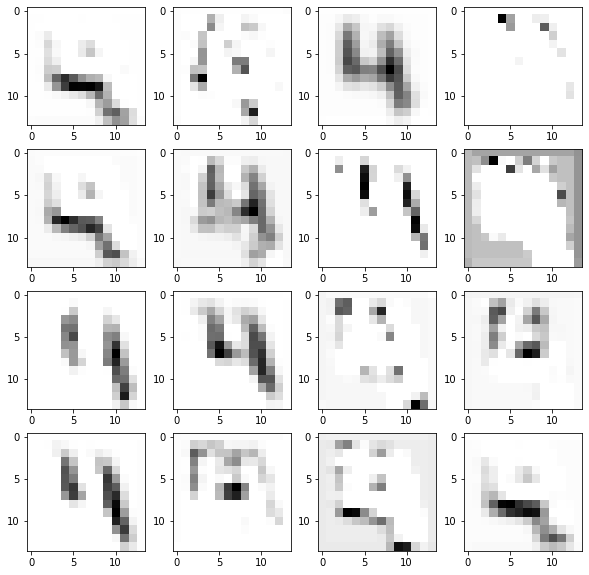

In [23]:
fig, ax = plt.subplots(nrows=4,ncols=4,figsize=[10,10])
fig.patch.set_facecolor('white')
pme=aconv1.transpose(3,0,1,2)
for i,axi in enumerate(ax.flat):
    axi.imshow(pme[i].reshape(pme.shape[-2:]), cmap='Greys')